# Description

 $\href{https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption}{Данные}$ PJM о почасовом потреблении энергии
PJM Interconnection LLC (PJM) — региональная передающая организация (RTO) в США. Он является частью сети Eastern Interconnection, управляющей системой электропередачи, обслуживающей все или некоторые штаты Делавэр, Иллинойс, Индиана, Кентукки, Мэриленд, Мичиган, Нью-Джерси, Северная Каролина, Огайо, Пенсильвания, Теннесси, Вирджиния, Западная Вирджиния и округ. Колумбии.

Данные о почасовом потреблении энергии взяты с веб-сайта PJM и указаны в мегаваттах (МВт).


# Import libraries

In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import optuna

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from sklearn.linear_model import LinearRegression
from prophet import Prophet
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# EDA


In [2]:
pjme = pd.read_csv('./PJME_hourly.csv',
                   index_col=[0], parse_dates=[0])

In [3]:
pjme.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145366 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


In [ ]:
pjme.head()

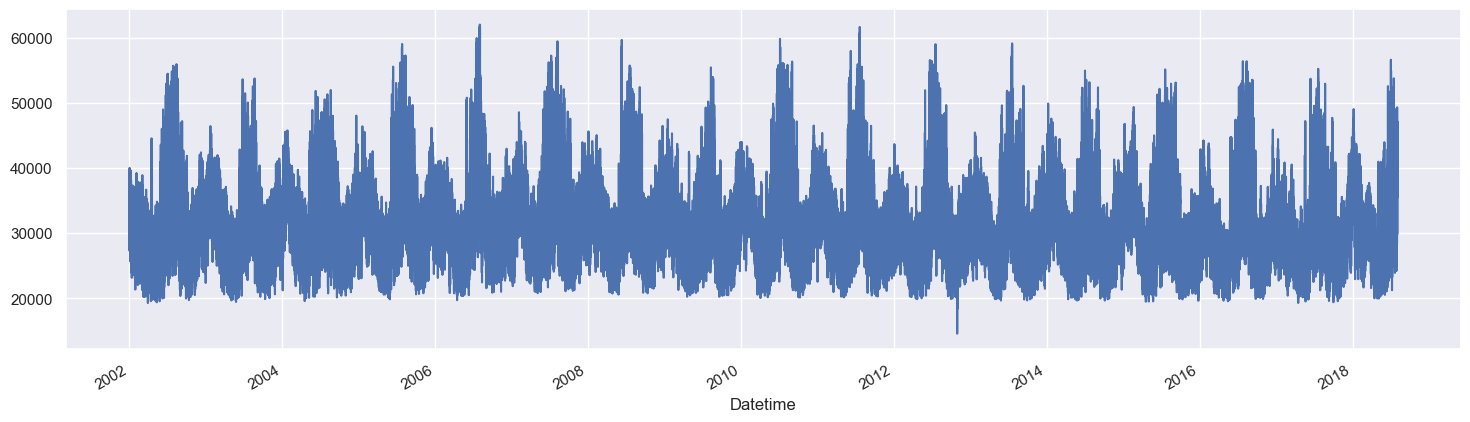

In [55]:
sns.set()
pjme.plot(figsize=(18,5)).legend().set_visible(False)

На общем графике виден выброс в конце 2012 года.

Рассмотрим это время подробнее

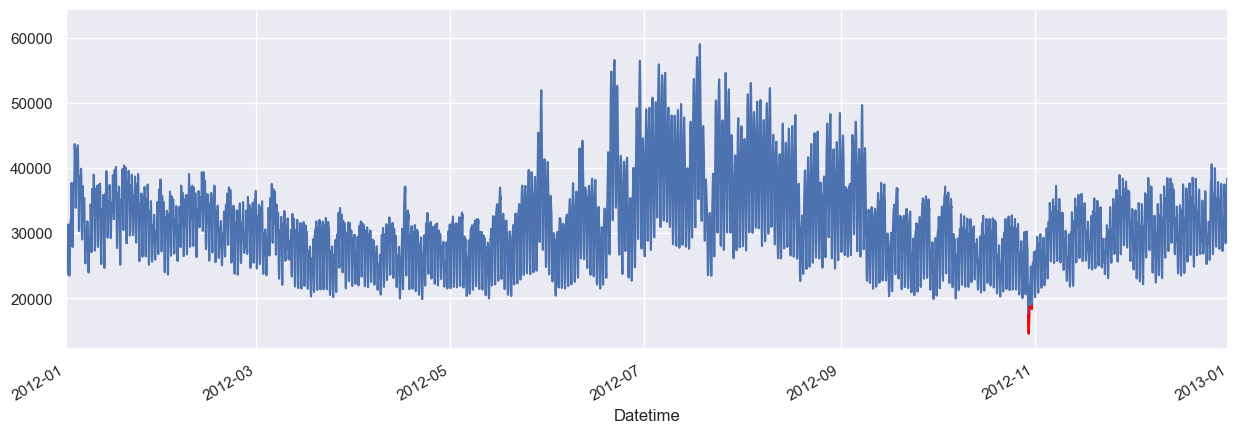

In [41]:
ax = pjme.plot(figsize=(18,5),
                     xlim=('01-01-2012','01-01-2013')
                    )
pjme.query('PJME_MW < 19000').plot(figsize=(15,5),
                                             color='red',
                                             ax=ax)
ax.legend().set_visible(False)

Удаляем выброс

In [56]:
pjme = pjme.query('PJME_MW > 19000')

Создадим новые признаки.

In [57]:
def create_features(data):

    df = pd.DataFrame(data.copy())
    df.columns = ["y"]
    
    df["hour"] = df.index.hour
    df["weekday"] = df.index.weekday
    df["is_weekend"] = df.weekday.isin([5, 6]) * 1  
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.weekofyear

    return df

In [58]:
pjme = create_features(pjme)

C:\Users\Sergey\AppData\Local\Temp\ipykernel_17884\4138050964.py:14: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['weekofyear'] = df.index.weekofyear


In [281]:
pjme.query('year == 2014')

y  hour  weekday  is_weekend  quarter  month  year  dayofyear  dayofmonth  weekofyear
Datetime                                                                                                        
2014-01-01 00:00:00  32595.0     0        2           0        1      1  2014          1           1           1
2014-12-31 01:00:00  30795.0     1        2           0        4     12  2014        365          31           1
2014-12-31 02:00:00  29995.0     2        2           0        4     12  2014        365          31           1
2014-12-31 03:00:00  29688.0     3        2           0        4     12  2014        365          31           1
2014-12-31 04:00:00  29767.0     4        2           0        4     12  2014        365          31           1
...                      ...   ...      ...         ...      ...    ...   ...        ...         ...         ...
2014-01-01 20:00:00  36193.0    20        2           0        1      1  2014          1           1           1
2014-01-01 21:00:00  35601.0    21        2           0        1      1  2014          1           1           1
2014-01-01 22:00:00  34242.0    22        2           0        1      1  2014          1           1           1
2014-01-01 23:00:00  32215.0    23        2           0        1      1  2014          1           1           1
2014-01-02 00:00:00  30159.0     0        3           0        1      1  2014          2           2           1

[8760 rows x 10 columns]

Данные не правильно упорядочены. После первого января идет 31 декабря. Данные идут снизу в вверх. Отсортируем данные правильно.

In [285]:
pjme = pjme.reset_index().sort_values(by='Datetime', ascending= True).set_index('Datetime')
pjme.head()

y  hour  weekday  is_weekend  quarter  month  year  dayofyear  dayofmonth  weekofyear
Datetime                                                                                                        
2002-01-01 01:00:00  30393.0     1        1           0        1      1  2002          1           1           1
2002-01-01 02:00:00  29265.0     2        1           0        1      1  2002          1           1           1
2002-01-01 03:00:00  28357.0     3        1           0        1      1  2002          1           1           1
2002-01-01 04:00:00  27899.0     4        1           0        1      1  2002          1           1           1
2002-01-01 05:00:00  28057.0     5        1           0        1      1  2002          1           1           1

TypeError: 'Legend' object is not callable

<Figure size 640x480 with 0 Axes>

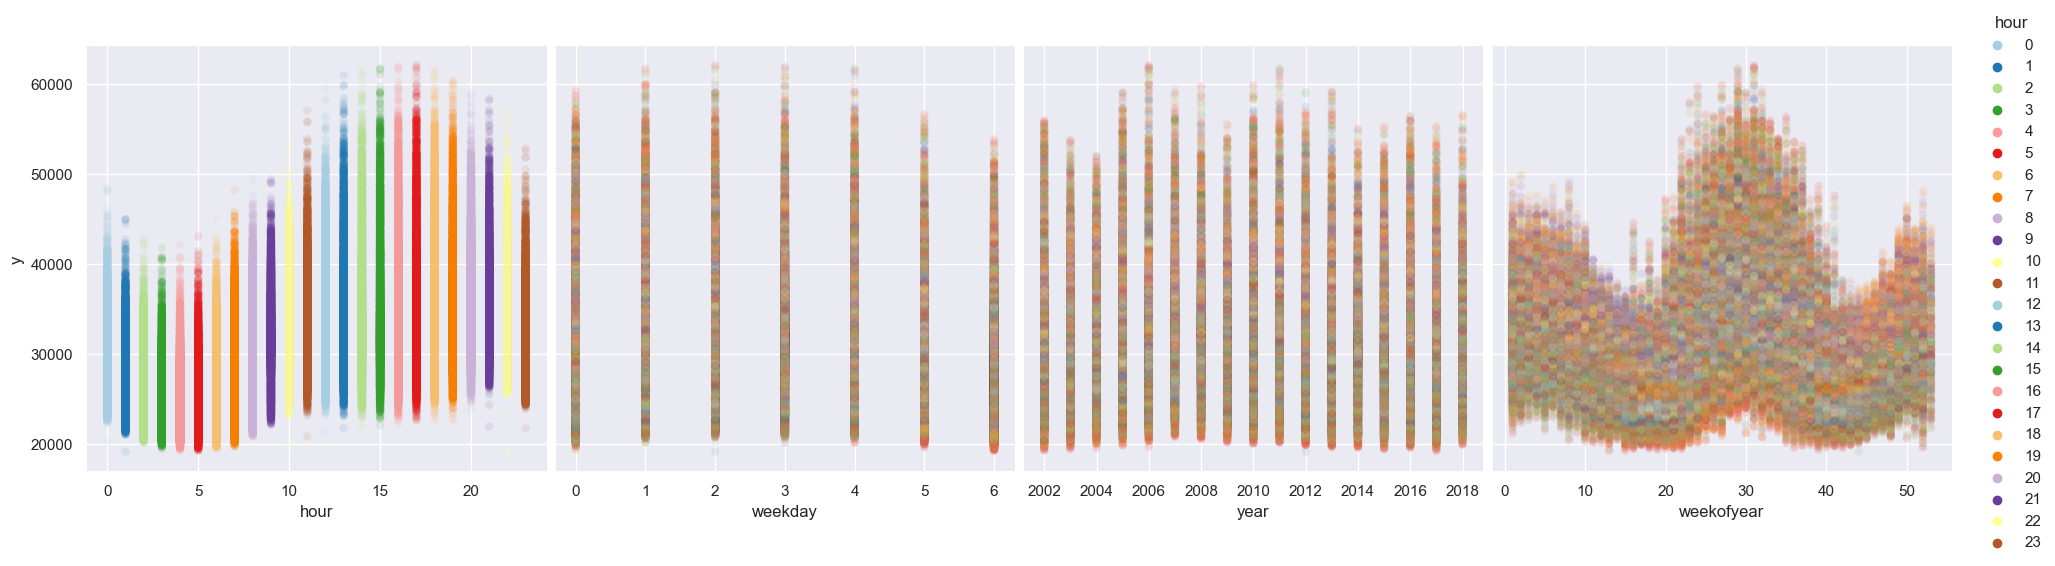

In [59]:
plt.figure(facecolor= "white")

ax = sns.pairplot(
    pjme.dropna(),
    hue='hour',
    x_vars=['hour','weekday', 'year','weekofyear'],
    y_vars='y',
    height=5,
    plot_kws={'alpha':0.1, 'linewidth': 0},
    palette = "Paired"
)

ax.legend().set_visible(False)
plt.tight_layout()
plt.show()

- На часовом графике видно, что пик использования электроэнергии приходится на 15-18 часов.
- На недельном графике видно, что на выходных объемы использования электроэнергии снижаются.
- По годам рост потребления электроэнергии не надлюдается.
- Летом самое высокое потребление электроэнергии.

In [60]:
def code_mean(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [312]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):

    data = pd.DataFrame(data.copy())

    test_index = int(len(data) * (1 - test_size))

    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)

    data["weekday_average"] = list(
        map(code_mean(data[:test_index], "weekday", "y").get, data.weekday)
    )
    data["hour_average"] = list(
        map(code_mean(data[:test_index], "hour", "y").get, data.hour)
    )
    data["quarter_average"] = list(
        map(code_mean(data[:test_index], "quarter", "y").get, data.quarter)
    )
    data["month_average"] = list(
        map(code_mean(data[:test_index], "month", "y").get, data.month)
    )  
    data["year_average"] = list(
        map(code_mean(data[:test_index], "year", "y").get, data.year)
    ) 
    data["dayofyear_average"] = list(
        map(code_mean(data[:test_index], "dayofyear", "y").get, data.dayofyear)
    )
    data["dayofmonth_average"] = list(
        map(code_mean(data[:test_index], "dayofmonth", "y").get, data.dayofmonth)
    )   
    
    data.drop(["hour", "weekday", 'weekofyear','quarter','month','year',  'dayofyear', 'dayofmonth', 'weekofyear' ], axis=1, inplace=True)
    
    data = data.dropna()
   # data = data.reset_index(drop=True)
    
    X_train = data.iloc[:test_index].drop(["y"], axis=1)
    y_train = data.iloc[:test_index]["y"]
    X_test = data.iloc[test_index:].drop(["y"], axis=1)
    y_test = data.iloc[test_index:]["y"]

    return X_train, X_test, y_train, y_test

В функциях выше мы создаем дополнительные признаки для временного ряда: 
- Предыдущие значения становятся новыми признаками;
- Средние по часу, недели, месяцу, кварталу, году, дню в году, месяцу в году.

# Baseline

Попробуем предсказать потребление электроэнергии с помощью простой линейной модели.

In [313]:
X_train, X_test, y_train, y_test = prepareData(
    pjme, test_size=0.3, lag_start=12, lag_end=48
)

In [300]:
linear = LinearRegression()
linear.fit(X_train, y_train)
lin_pred_y = linear.predict(X_test)

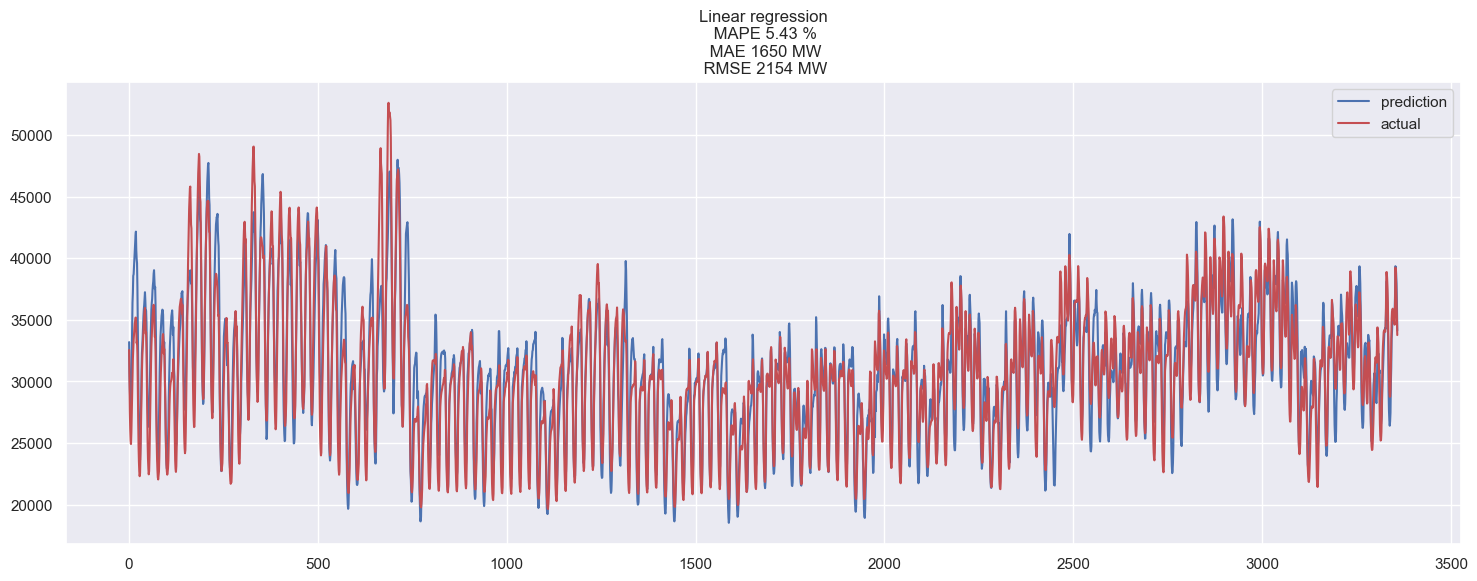

In [418]:
plt.figure(figsize=(18, 6))
plt.plot(lin_pred_y,  label="prediction")
plt.plot(y_test.values,"r", label="actual")
plt.legend(loc="best")
plt.title(
    "Linear regression\n MAPE {} %\n MAE {} MW\n RMSE {} MW".format(
        round(mean_absolute_percentage_error(y_test, lin_pred_y) * 100, 2),
        round(mean_absolute_error(y_test, lin_pred_y)),
        round(mean_squared_error(y_test, lin_pred_y) ** 0.5)
    )
)
plt.grid(True);

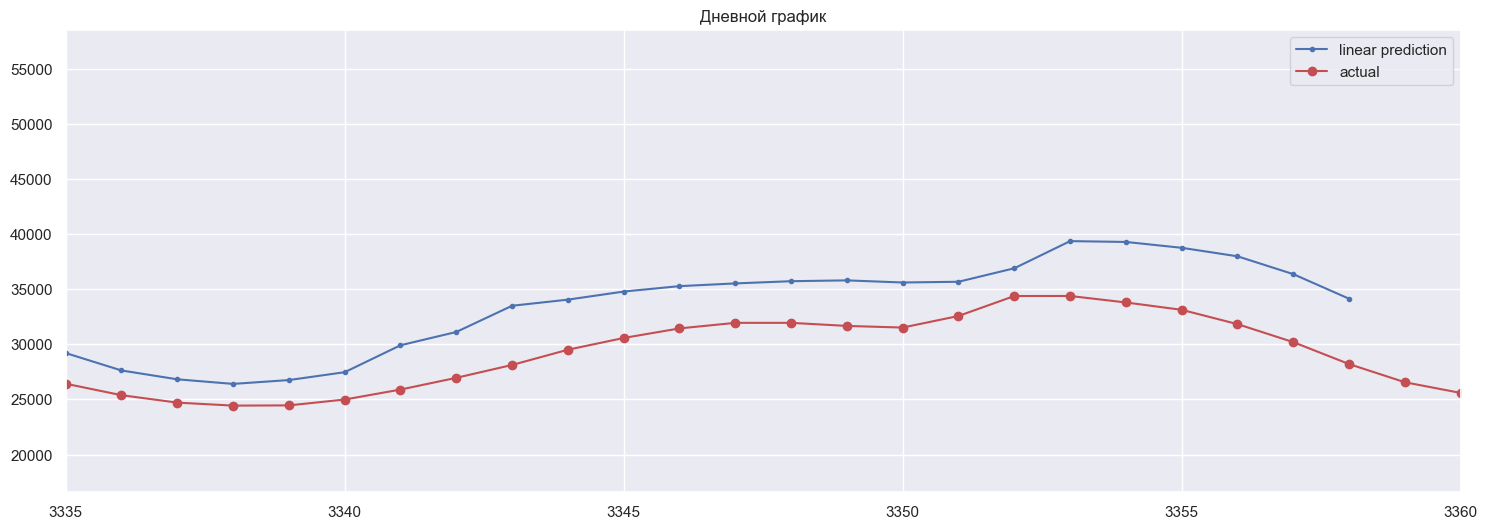

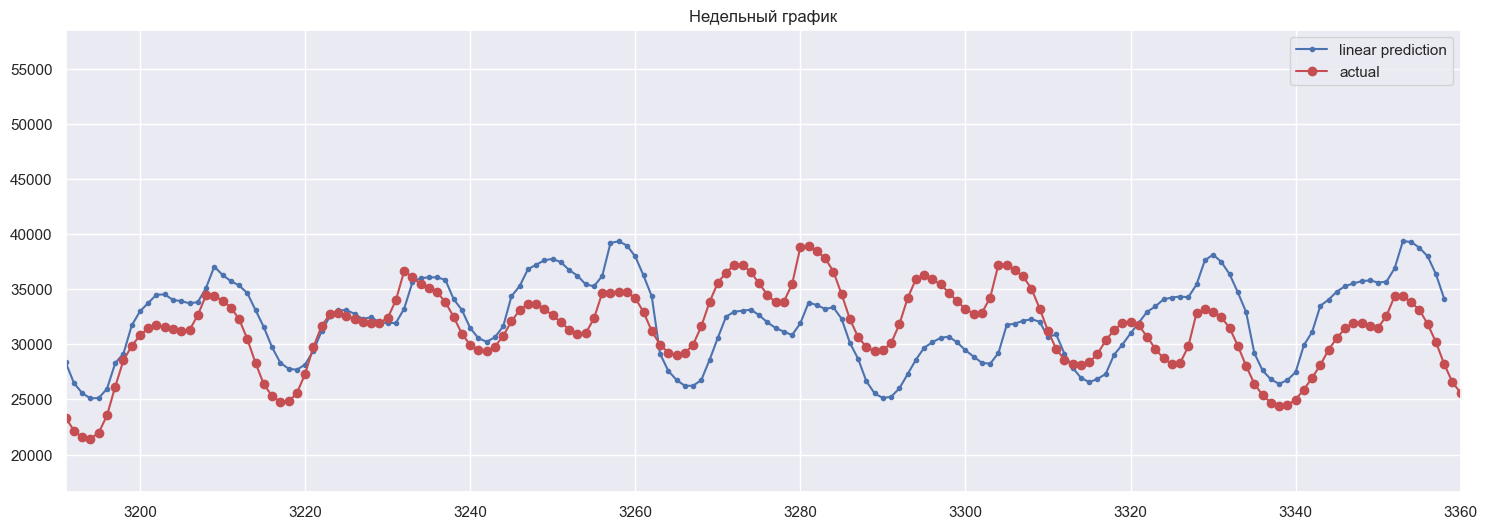

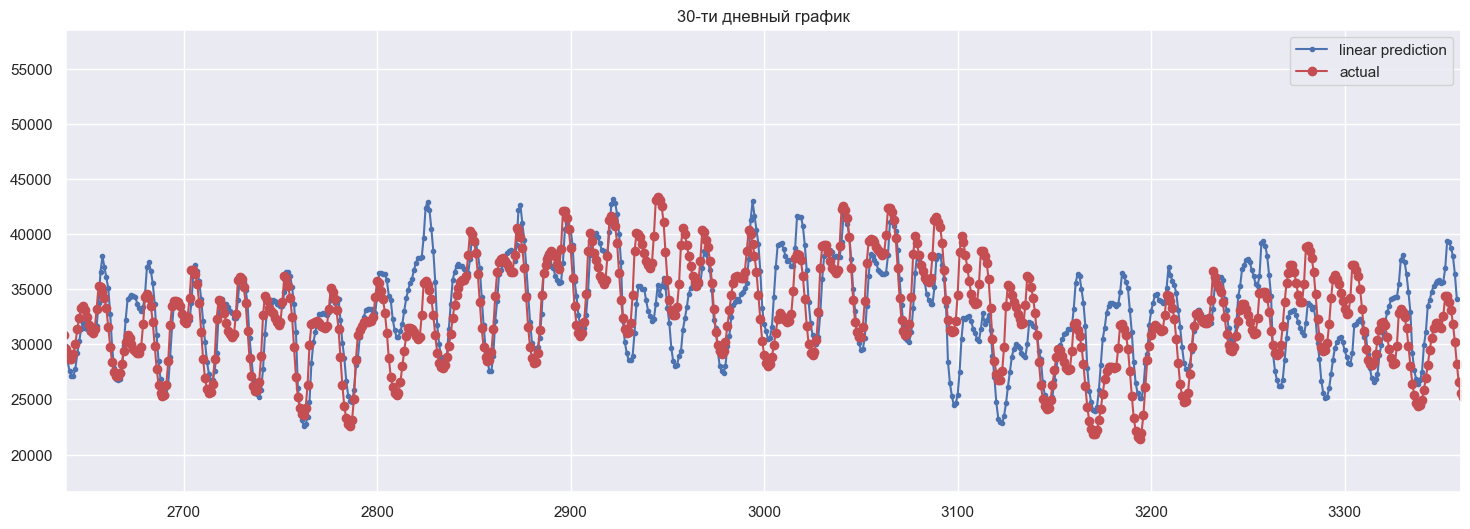

In [436]:
gr_type = {'Дневной':1, "Недельный": 7, "30-ти дневный": 30}

for i in gr_type:
    f, ax = plt.subplots(figsize = (18,6))
    plt.plot(lin_pred_y, "b",marker='.', label="linear prediction")
    plt.plot(pjme_test['y'].values, "r", marker='o', label="actual")
    plt.legend(loc="best")
    ax.set_xbound(
        lower=X_test.shape[0] - 24 * gr_type.get(i),
        upper=X_test.shape[0] + 1
    )
    plt.title("{} график".format(i))
    plt.show()

RMSE не значительно превышает MAE, что говорит об отсутствии больших выбросов.

# Prophet

In [327]:
prophet_pjme = pjme['y'].copy()

In [356]:
pjme_train = prophet_pjme.reset_index().rename(columns={'Datetime':'ds'}).loc[:int(len(prophet_pjme) * 0.7)]

In [355]:
pjme_test = prophet_pjme.reset_index().rename(columns={'Datetime':'ds'}).loc[int(len(prophet_pjme) * 0.7):]

In [357]:
model = Prophet()
model.fit(pjme_train)

12:37:55 - cmdstanpy - INFO - Chain [1] start processing
12:38:45 - cmdstanpy - INFO - Chain [1] done processing


In [361]:
pjme_forecast = model.predict(df=pjme_test)

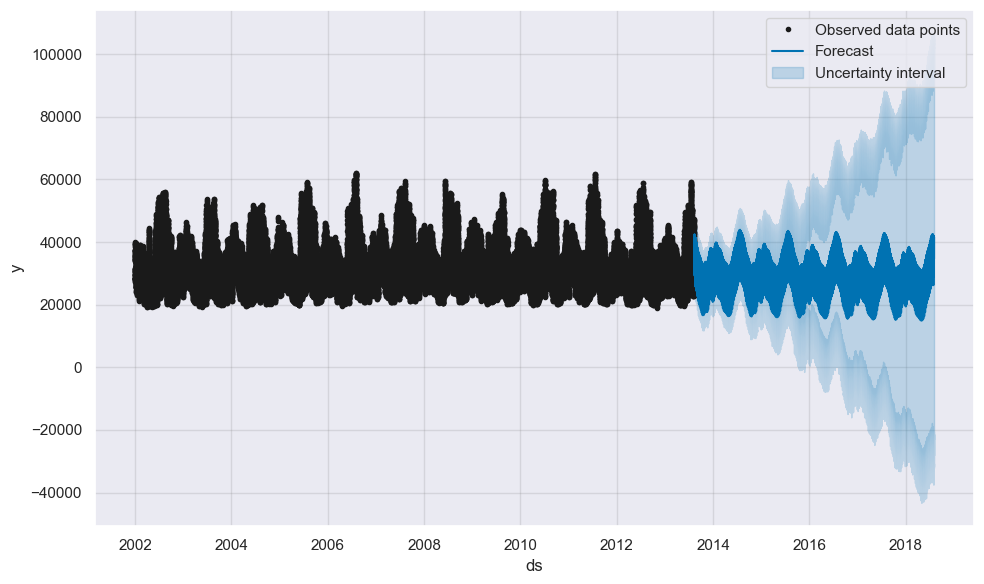

In [362]:
fig1 = model.plot(pjme_forecast, include_legend=True)

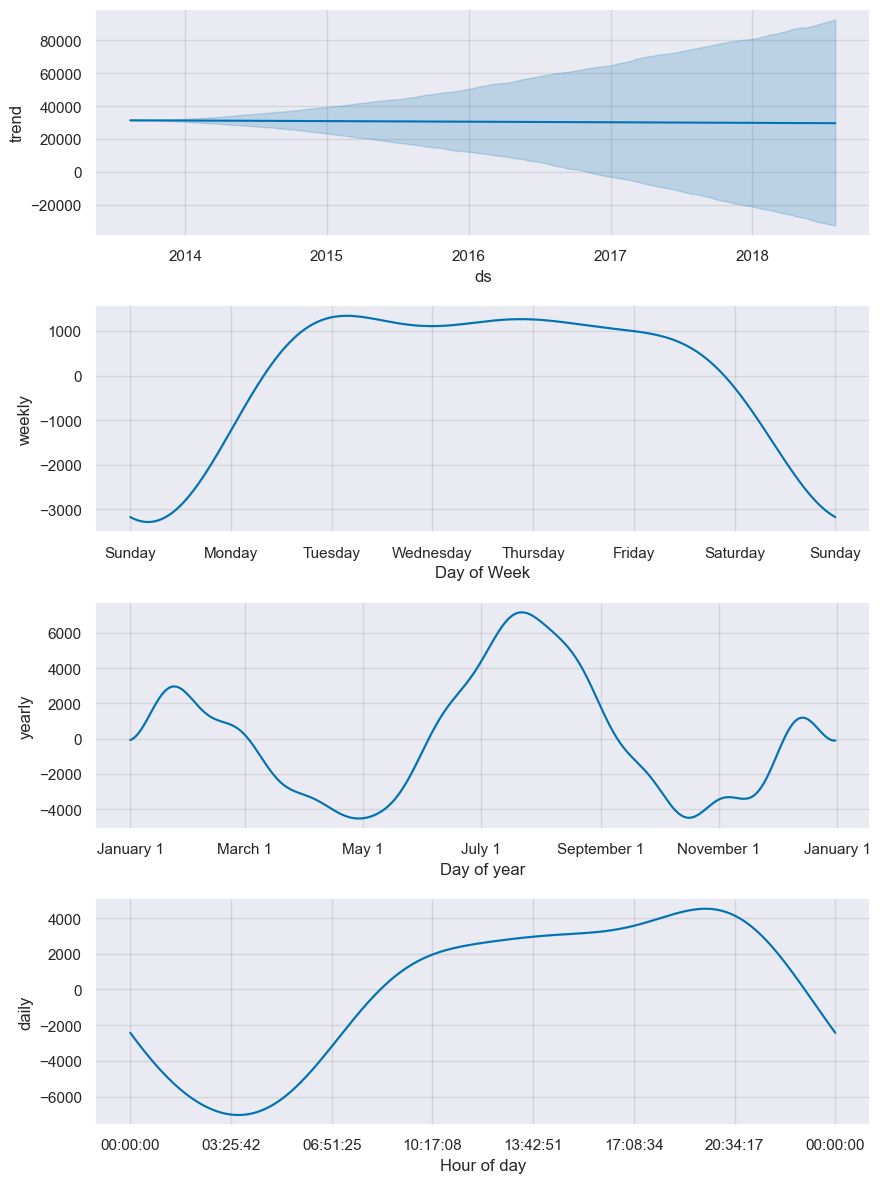

In [363]:
fig2 = model.plot_components(pjme_forecast)

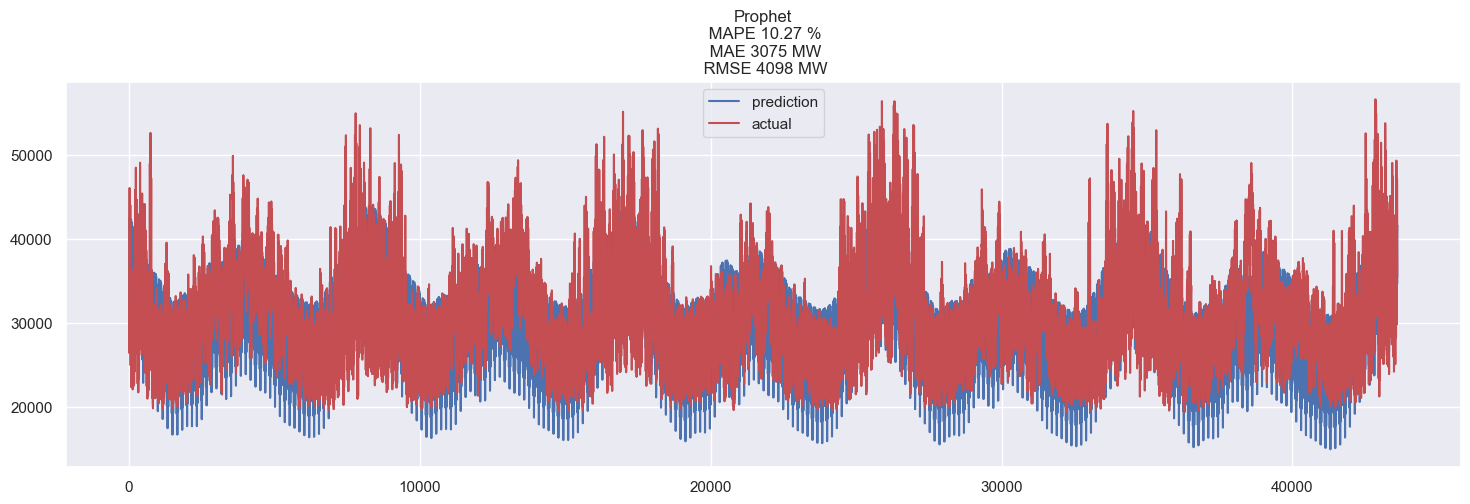

In [434]:
plt.figure(figsize=(18, 5))
plt.plot(pjme_forecast['yhat'], label="prediction")
plt.plot(pjme_test['y'].values,"r", label="actual")
plt.legend(loc="best")
plt.title(
    "Prophet forecast\n MAPE {} %\n MAE {} MW\n RMSE {} MW".format(
        round(mean_absolute_percentage_error(pjme_forecast['yhat'], pjme_test['y'])* 100, 2),
        round(mean_absolute_error(pjme_forecast['yhat'], pjme_test['y'])),
        round(mean_squared_error(pjme_forecast['yhat'], pjme_test['y']) ** 0.5)
    )
)
plt.grid(True);

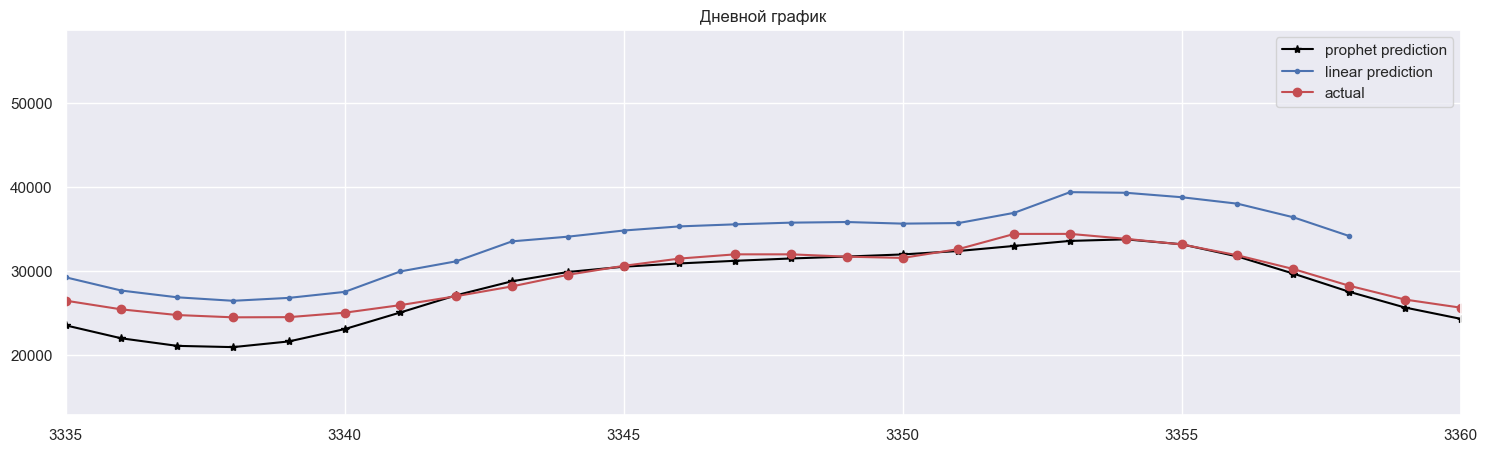

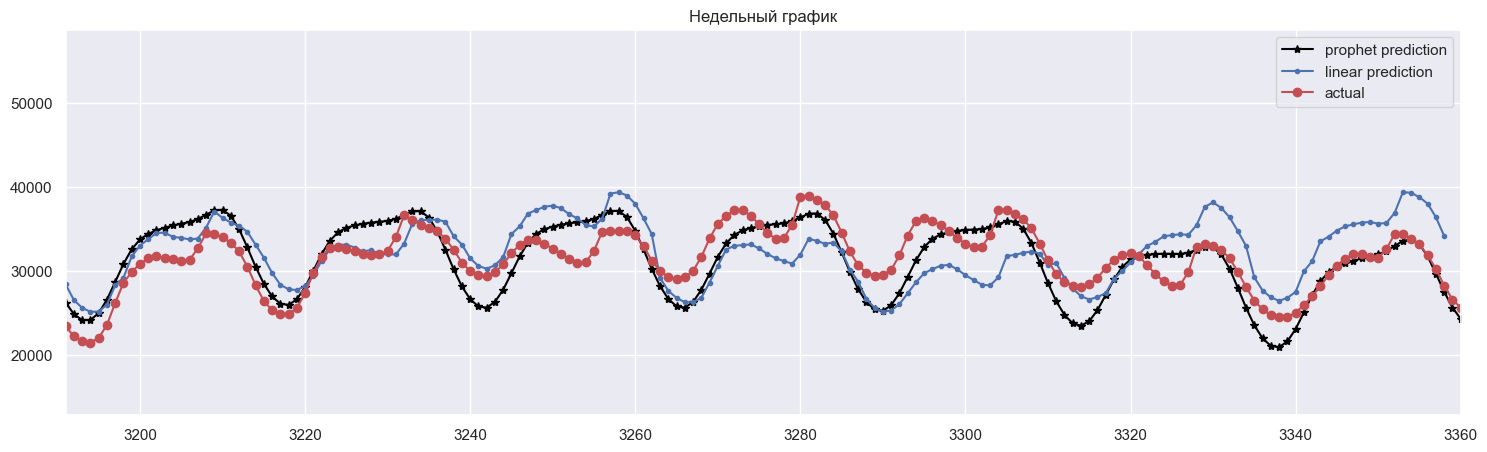

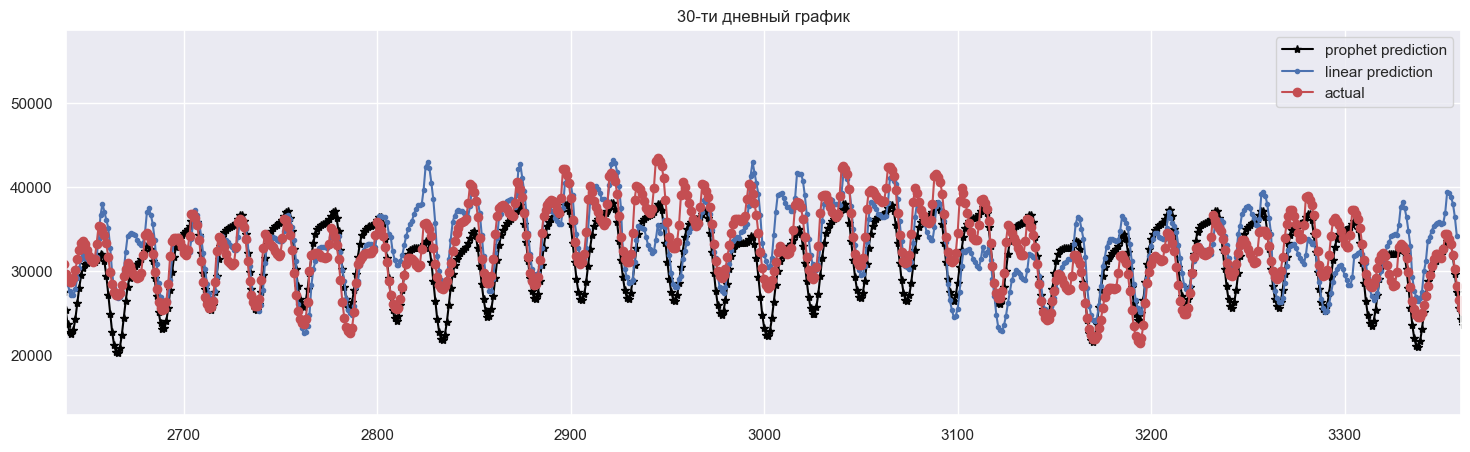

In [437]:
for i in gr_type:
    f, ax = plt.subplots(figsize = (18,5))
    plt.plot(pjme_forecast['yhat'], "black",marker='*', label="prophet prediction")
    plt.plot(lin_pred_y, "b",marker='.', label="linear prediction")
    plt.plot(pjme_test['y'].values, "r", marker='o', label="actual")
    plt.legend(loc="best")
    ax.set_xbound(
        lower=X_test.shape[0] - 24 * gr_type.get(i),
        upper=X_test.shape[0] + 1
    )
    plt.title("{} график".format(i))
    plt.show()

Prophet справился хуже линейной модели. Склонен занижать прогноз.

# Boosting models

## Selection of hyperparameters with OPTUNA

In [137]:
def objective(trial):
    classifier_name = trial.suggest_categorical(
        "classifier", ["XGB", "LGBM", "CatBoost"])

    if classifier_name == "XGB":
        params = {
            'random_state': 777,
            'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
            'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
            'gamma': trial.suggest_float('gamma', 0.01, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3,  1.0),
            'subsample': trial.suggest_float('subsample', 0.1, 1.0),
            'learning_rate': trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 100, 4000),
            'max_depth': trial.suggest_int('max_depth', 2, 30, log=True),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 300)
        }
        classifier_obj = XGBRegressor(**params)

    elif classifier_name == "LGBM":
        params = {
            'metric': 'rmse',
            'random_state': 777,
            'n_estimators': trial.suggest_int('n_estimators', 100, 20000),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
            'subsample': trial.suggest_float('subsample', 0.4, 1.0),
            'learning_rate': trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
            'max_depth': trial.suggest_int('max_depth', 2, 30, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 1, 1000),
            'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
            'cat_smooth': trial.suggest_int('min_data_per_groups', 1, 100)
        }
        classifier_obj = LGBMRegressor(**params)

    elif classifier_name == "CatBoost":
        params = {
            'random_state': 777,
            'iterations': trial.suggest_int("iterations", 100, 1000),
            'learning_rate': trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
            'depth': trial.suggest_int("depth", 4, 10),
            'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
            'bootstrap_type': trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
            'random_strength': trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
            'bagging_temperature': trial.suggest_float("bagging_temperature", 0.0, 10.0),
            'od_type': trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
            'od_wait': trial.suggest_int("od_wait", 10, 50),
        }
        classifier_obj = CatBoostRegressor(**params, verbose=False)

    classifier_obj.fit(X_train, y_train)
    y_pred = classifier_obj.predict(X_test)
    MAE = mean_absolute_error(y_test, y_pred)
    return MAE

In [139]:
study = optuna.create_study(
    direction="minimize",
    pruner=optuna.pruners.HyperbandPruner(
        min_resource=1, max_resource=100, reduction_factor=3
    ),
)
study.optimize(objective, n_trials=100)

[I 2023-02-14 17:18:30,227] A new study created in memory with name: no-name-30256d41-8267-4b68-9eb5-a7936a113d8a
[I 2023-02-14 17:20:07,089] Trial 0 finished with value: 4119.16601079412 and parameters: {'classifier': 'XGB', 'lambda': 0.07228905884155198, 'alpha': 1.672725038738464, 'gamma': 0.5669099905560475, 'colsample_bytree': 0.3144656286178884, 'subsample': 0.6688768276830763, 'learning_rate': 0.0011527931591595812, 'n_estimators': 1721, 'max_depth': 7, 'min_child_weight': 90}. Best is trial 0 with value: 4119.16601079412.
[I 2023-02-14 17:20:41,375] Trial 1 finished with value: 1442.4212984701346 and parameters: {'classifier': 'LGBM', 'reg_alpha': 2.530022801007709, 'reg_lambda': 0.13119210607354928, 'colsample_bytree': 0.49107191032055375, 'subsample': 0.9519313856780329, 'learning_rate': 0.007767615716744023, 'max_depth': 2, 'num_leaves': 696, 'min_child_samples': 33, 'min_data_per_groups': 42}. Best is trial 1 with value: 1442.4212984701346.
[I 2023-02-14 17:21:04,646] Trial

[I 2023-02-14 17:46:41,287] Trial 19 finished with value: 1280.6061368096075 and parameters: {'classifier': 'LGBM', 'reg_alpha': 1.1080374207146257, 'reg_lambda': 0.09233865799867823, 'colsample_bytree': 0.48544622402500703, 'subsample': 0.6202330711588455, 'learning_rate': 0.060173939781629805, 'max_depth': 7, 'num_leaves': 806, 'min_child_samples': 202, 'min_data_per_groups': 72}. Best is trial 17 with value: 1241.0734201005107.
[I 2023-02-14 17:48:04,816] Trial 20 finished with value: 1250.9749295956722 and parameters: {'classifier': 'LGBM', 'reg_alpha': 6.880381747959917, 'reg_lambda': 0.005974866974495345, 'colsample_bytree': 0.6827723515828124, 'subsample': 0.44462136633067717, 'learning_rate': 0.004284832476977457, 'max_depth': 6, 'num_leaves': 553, 'min_child_samples': 90, 'min_data_per_groups': 71}. Best is trial 17 with value: 1241.0734201005107.
[I 2023-02-14 17:49:26,979] Trial 21 finished with value: 1249.0201476813343 and parameters: {'classifier': 'LGBM', 'reg_alpha': 9.

[I 2023-02-14 18:14:51,648] Trial 38 finished with value: 1827.129696402508 and parameters: {'classifier': 'CatBoost', 'iterations': 504, 'learning_rate': 0.01374507892382738, 'depth': 4, 'l2_leaf_reg': 1.631977244205041e-08, 'bootstrap_type': 'Bayesian', 'random_strength': 7.665162779273506, 'bagging_temperature': 9.752571161783196, 'od_type': 'IncToDec', 'od_wait': 11}. Best is trial 35 with value: 1240.7431716824449.
[I 2023-02-14 18:16:08,172] Trial 39 finished with value: 1246.7274988762497 and parameters: {'classifier': 'LGBM', 'reg_alpha': 9.588974258292556, 'reg_lambda': 0.002724423331605411, 'colsample_bytree': 0.5072874141960668, 'subsample': 0.92202681804204, 'learning_rate': 0.008476401156844154, 'max_depth': 7, 'num_leaves': 373, 'min_child_samples': 175, 'min_data_per_groups': 84}. Best is trial 35 with value: 1240.7431716824449.
[I 2023-02-14 18:17:37,330] Trial 40 finished with value: 1248.0837970832608 and parameters: {'classifier': 'LGBM', 'reg_alpha': 0.7821416526917

[I 2023-02-14 18:35:30,513] Trial 57 finished with value: 1246.079518087505 and parameters: {'classifier': 'LGBM', 'reg_alpha': 0.1416540666694787, 'reg_lambda': 3.1999066890746035, 'colsample_bytree': 0.40767265744645315, 'subsample': 0.871726369775777, 'learning_rate': 0.016659939093617435, 'max_depth': 5, 'num_leaves': 646, 'min_child_samples': 279, 'min_data_per_groups': 79}. Best is trial 35 with value: 1240.7431716824449.
[I 2023-02-14 18:36:08,461] Trial 58 finished with value: 1262.697940638779 and parameters: {'classifier': 'LGBM', 'reg_alpha': 0.07146529545611723, 'reg_lambda': 1.0700176142682178, 'colsample_bytree': 0.41540654594964593, 'subsample': 0.8663303832579153, 'learning_rate': 0.016849457660273195, 'max_depth': 4, 'num_leaves': 913, 'min_child_samples': 253, 'min_data_per_groups': 39}. Best is trial 35 with value: 1240.7431716824449.
[I 2023-02-14 18:38:26,576] Trial 59 finished with value: 1282.999553383034 and parameters: {'classifier': 'LGBM', 'reg_alpha': 0.3135

[I 2023-02-14 18:53:55,365] Trial 76 finished with value: 1250.5785246065243 and parameters: {'classifier': 'LGBM', 'reg_alpha': 0.00225234169507963, 'reg_lambda': 0.10602817981385149, 'colsample_bytree': 0.8591567259956104, 'subsample': 0.731180563777699, 'learning_rate': 0.019500361662019978, 'max_depth': 7, 'num_leaves': 851, 'min_child_samples': 160, 'min_data_per_groups': 60}. Best is trial 73 with value: 1238.6423549106783.
[I 2023-02-14 18:55:01,250] Trial 77 finished with value: 1244.6123045619204 and parameters: {'classifier': 'LGBM', 'reg_alpha': 0.0010174192186444162, 'reg_lambda': 0.05244809847239361, 'colsample_bytree': 0.7160009624036082, 'subsample': 0.6448588329703117, 'learning_rate': 0.015502651069963456, 'max_depth': 7, 'num_leaves': 902, 'min_child_samples': 264, 'min_data_per_groups': 71}. Best is trial 73 with value: 1238.6423549106783.
[I 2023-02-14 18:57:14,658] Trial 78 finished with value: 1281.2708119164297 and parameters: {'classifier': 'XGB', 'lambda': 0.86

[I 2023-02-14 19:18:36,958] Trial 95 finished with value: 1252.5952864606927 and parameters: {'classifier': 'LGBM', 'reg_alpha': 0.015789532180245924, 'reg_lambda': 0.0048619232242884955, 'colsample_bytree': 0.5888928027282525, 'subsample': 0.6863892934715817, 'learning_rate': 0.014064872732720573, 'max_depth': 10, 'num_leaves': 870, 'min_child_samples': 230, 'min_data_per_groups': 19}. Best is trial 91 with value: 1237.6259158034393.
[I 2023-02-14 19:19:45,492] Trial 96 finished with value: 1240.9270910435182 and parameters: {'classifier': 'LGBM', 'reg_alpha': 0.036862972729741546, 'reg_lambda': 0.1390508851858644, 'colsample_bytree': 0.6477506863097809, 'subsample': 0.7069946359244097, 'learning_rate': 0.009590216892187812, 'max_depth': 6, 'num_leaves': 793, 'min_child_samples': 242, 'min_data_per_groups': 27}. Best is trial 91 with value: 1237.6259158034393.
[I 2023-02-14 19:23:35,169] Trial 97 finished with value: 1292.5204650592073 and parameters: {'classifier': 'XGB', 'lambda': 0

In [140]:
optuna.visualization.plot_optimization_history(study)

In [145]:
models = study.trials_dataframe()

In [196]:
models.query('params_classifier == "XGB" ').sort_values(by= 'value')

number        value             datetime_start          datetime_complete  \
28      28  1266.221511 2023-02-14 17:58:48.914788 2023-02-14 18:04:53.252384   
11      11  1266.743948 2023-02-14 17:27:19.126957 2023-02-14 17:33:57.027015   
47      47  1274.676152 2023-02-14 18:25:14.763749 2023-02-14 18:29:17.978235   
78      78  1281.270812 2023-02-14 18:55:01.251088 2023-02-14 18:57:14.657522   
5        5  1290.418490 2023-02-14 17:22:46.163506 2023-02-14 17:23:19.841126   
97      97  1292.520465 2023-02-14 19:19:45.493532 2023-02-14 19:23:35.168930   
66      66  1312.234092 2023-02-14 18:43:58.338848 2023-02-14 18:44:59.695846   
30      30  1498.402707 2023-02-14 18:04:55.372633 2023-02-14 18:06:43.627457   
37      37  1578.494271 2023-02-14 18:14:26.814525 2023-02-14 18:14:46.630045   
2        2  1625.224805 2023-02-14 17:20:41.377779 2023-02-14 17:21:04.645368   
0        0  4119.166011 2023-02-14 17:18:30.229941 2023-02-14 17:20:07.089543   

                 duration  params_alpha  params_bagging_temperature  \
28 0 days 00:06:04.337596      1.999461                         NaN   
11 0 days 00:06:37.900058      0.001455                         NaN   
47 0 days 00:04:03.214486      0.431020                         NaN   
78 0 days 00:02:13.406434      0.006275                         NaN   
5  0 days 00:00:33.677620      0.025199                         NaN   
97 0 days 00:03:49.675398      0.459072                         NaN   
66 0 days 00:01:01.356998      0.014889                         NaN   
30 0 days 00:01:48.254824      0.001650                         NaN   
37 0 days 00:00:19.815520      9.870940                         NaN   
2  0 days 00:00:23.267589      0.045951                         NaN   
0  0 days 00:01:36.859602      1.672725                         NaN   

   params_bootstrap_type params_classifier  params_colsample_bytree  ...  \
28                   NaN               XGB                 0.706131  ...   
11                   NaN               XGB                 0.990413  ...   
47                   NaN               XGB                 0.601828  ...   
78                   NaN               XGB                 0.655944  ...   
5                    NaN               XGB                 0.943000  ...   
97                   NaN               XGB                 0.644296  ...   
66                   NaN               XGB                 0.613041  ...   
30                   NaN               XGB                 0.595304  ...   
37                   NaN               XGB                 0.599909  ...   
2                    NaN               XGB                 0.566418  ...   
0                    NaN               XGB                 0.314466  ...   

    params_min_data_per_groups  params_n_estimators  params_num_leaves  \
28                         NaN               3778.0                NaN   
11                         NaN               3768.0                NaN   
47                         NaN               2707.0                NaN   
78                         NaN               2717.0                NaN   
5                          NaN                243.0                NaN   
97                         NaN               3384.0                NaN   
66                         NaN               1121.0                NaN   
30                         NaN               2555.0                NaN   
37                         NaN                286.0                NaN   
2                          NaN               1261.0                NaN   
0                          NaN               1721.0                NaN   

    params_od_type  params_od_wait  params_random_strength  params_reg_alpha  \
28             NaN             NaN                     NaN               NaN   
11             NaN             NaN                     NaN               NaN   
47             NaN             NaN                     NaN               NaN   
78             NaN             NaN                     N

In [300]:
study.best_trial.params

{'classifier': 'LGBM',
 'reg_alpha': 0.00488598237851377,
 'reg_lambda': 0.08169486223175351,
 'colsample_bytree': 0.6447519572739667,
 'subsample': 0.7710079289936309,
 'learning_rate': 0.017935849432015576,
 'max_depth': 6,
 'num_leaves': 952,
 'min_child_samples': 197,
 'min_data_per_groups': 57}

In [294]:
models.to_csv("params.csv", index= False)

## Training models

In [420]:
lgbm_params = {
 'reg_alpha': 0.005,
 'reg_lambda': 0.08,
 'colsample_bytree': 0.64,
 'subsample': 0.77,
 'learning_rate': 0.0179,
 'max_depth': 6,
 'num_leaves': 952,
 'min_child_samples': 197,
 'n_estimators': 10000
}

In [421]:
cat_params = {
    'iterations': 775,
    'learning_rate': 0.02,
    'depth': 7,
    'l2_leaf_reg': 2.63,
    'bootstrap_type': 'Bayesian',
    'random_strength': 8.87,
    'bagging_temperature': 2.68,
    'od_type': 'IncToDec', 'od_wait': 41
             }

In [422]:
XGB_params = {
    'lambda': 0.00125,
    'alpha': 2,
    'gamma': 0.03,
    'colsample_bytree': 0.7,
    'subsample': 0.33,
    'learning_rate': 0.015,
    'n_estimators': 3780,
    'max_depth': 11,
    'min_child_weight': 277
    }

In [424]:
lgbm = LGBMRegressor(**lgbm_params)

In [426]:
lgbm.fit(X_train, y_train)

lgbm_y_pred = lgbm.predict(X_test)
mean_absolute_error(y_test, lgbm_y_pred)

1271.7484574332732

In [429]:
cat = CatBoostRegressor(**cat_params, verbose= False)

In [430]:
cat.fit(X_train, y_train)

cat_y_pred = cat.predict(X_test)
mean_absolute_error(y_test, cat_y_pred)

1481.082286937279

In [431]:
xgb = XGBRegressor(**XGB_params)

In [432]:
xgb.fit(X_train, y_train)

xgb_y_pred = xgb.predict(X_test)
mean_absolute_error(y_test, xgb_y_pred)

1311.948850685658

На тестовой выборке LGBM показал так же меньшую ошибку.

# Вывод

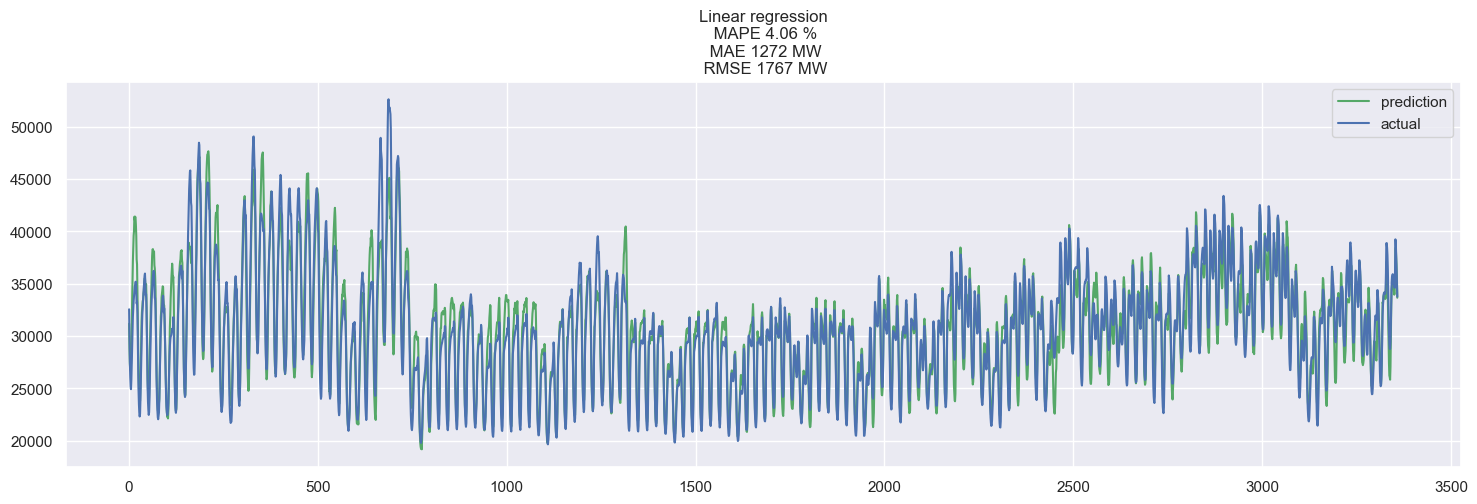

In [433]:
plt.figure(figsize=(18, 5))
plt.plot(lgbm_y_pred, "g", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title(
    "LGBM regressor\n MAPE {} %\n MAE {} MW\n RMSE {} MW".format(
        round(mean_absolute_percentage_error(y_test, lgbm_y_pred)* 100, 2),
        round(mean_absolute_error(y_test, lgbm_y_pred)),
        round(mean_squared_error(y_test, lgbm_y_pred) ** 0.5)
    )
)
plt.grid(True);

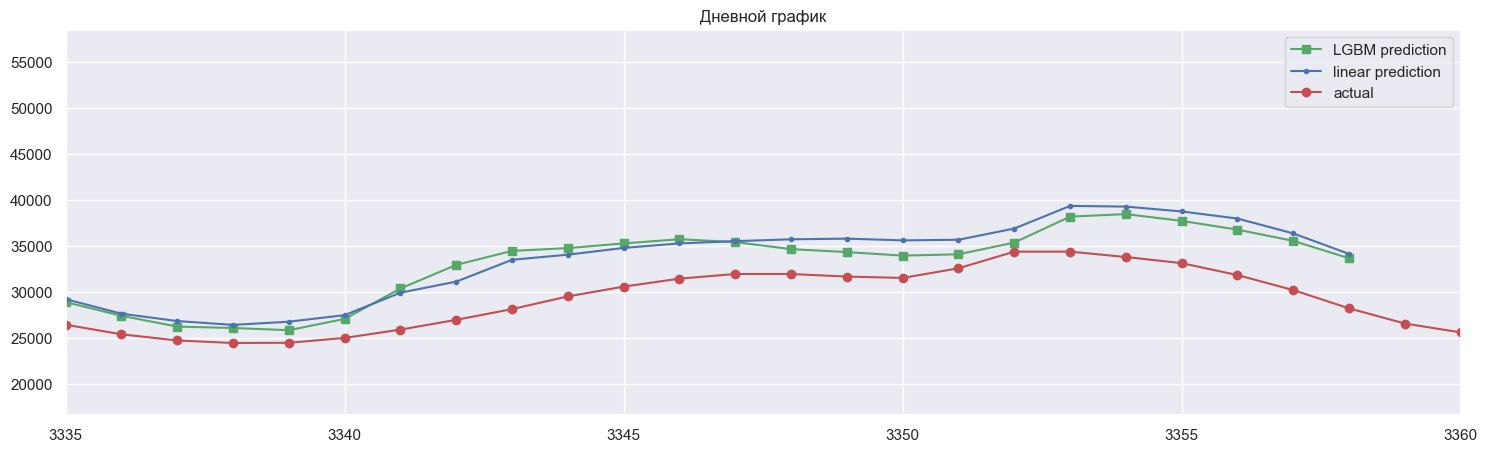

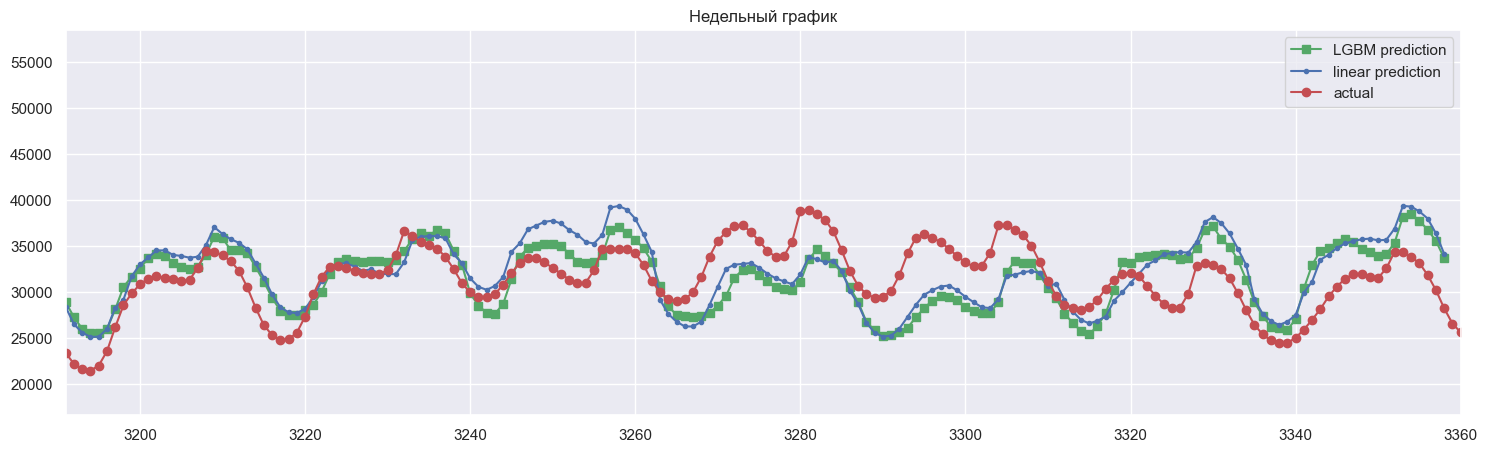

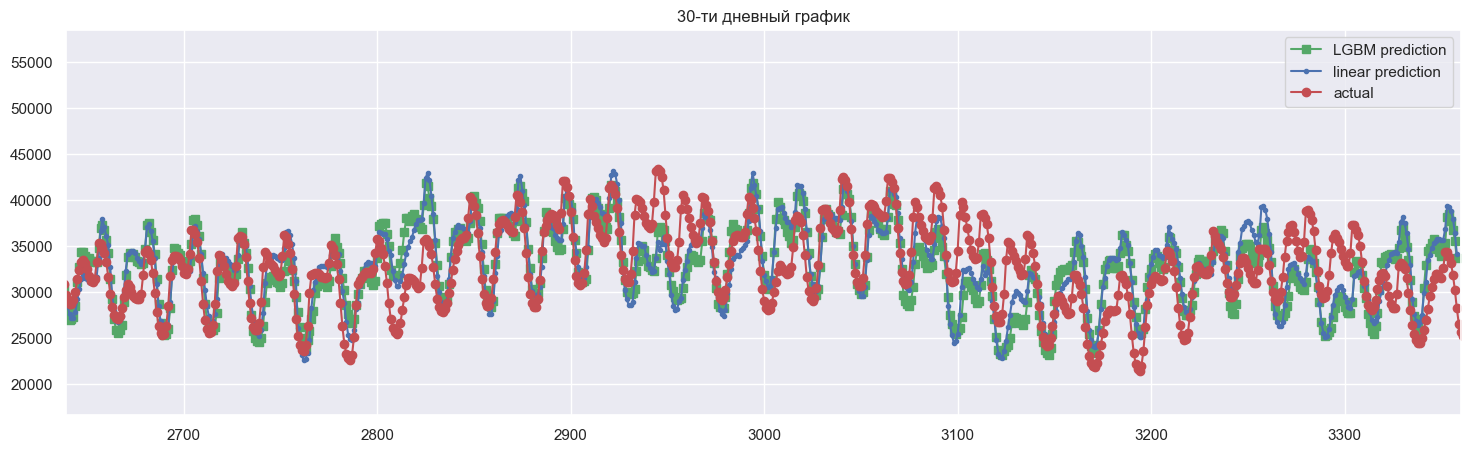

In [442]:
for i in gr_type:
    f, ax = plt.subplots(figsize = (18,5))
    
    plt.plot(lgbm_y_pred, "g",marker='s', label="LGBM prediction")
  #  plt.plot(pjme_forecast['yhat'], "black",marker='*', label="prophet prediction")
    plt.plot(lin_pred_y, "b",marker='.', label="linear prediction")
    plt.plot(pjme_test['y'].values, "r", marker='o', label="actual")
    plt.legend(loc="best")
    ax.set_xbound(
        lower=X_test.shape[0] - 24 * gr_type.get(i),
        upper=X_test.shape[0] + 1
    )
    plt.title("{} график".format(i))
    plt.show()

LGBM незначительно улучшил метрики относительно линейной модели, при этом подбор гиперпараметов и обучение модели заняло значительно больше времени.